# PyMultiNest My Models

In [1]:
from __future__ import absolute_import, unicode_literals, print_function
import pymultinest
import math
import os
import threading, subprocess
from sys import platform

from pylab import *;ion()

if not os.path.exists("chains"): os.mkdir("chains")

** Straight Line **

In [ ]:
%matplotlib inline
from pylab import *;ion()

from pymultinest.solve import Solver,solve
from numpy import pi, sin, cos, linspace

def gaussian1D(cube):
    # cube = np.float32(cube)
    return lambda y: np.exp(-0.5*(( (cube[0] - y) / cube[1])**2)) / sqrt(2*pi*cube[1]**2)

def straight_line(cube):
    offset = cube[0]
    slope  = cube[1]
    return lambda abscissa: offset + slope * abscissa

def sine_wave(cube):
    amp    = cube[0]
    period = cube[1]
    return lambda abscissa: amp*sin(2*pi / period * abscissa)

np.random.seed(42)

param0= 0.5#0.05
param1= 0.9#5*pi
yunc  = 0.1
nPts  = int(50)
nThPts= int(1e3)

xmin  = -1#*pi
xmax  =  1#*pi
dx    = 0.1*(xmax - xmin)

model = straight_line; parameters = ["offset", "slope"]
# model = sine_wave; parameters = ["amp", "period"]
# model = gaussian1D; parameters = ["center", "width"]

yuncs = np.random.normal(yunc, 1e-2 * yunc, nPts)
thdata= np.linspace(xmin-dx, xmax+dx, nThPts)

xdata = np.random.uniform(xmin, xmax, nPts)
xdata = sort(xdata)

ydata = model([param0,param1])(xdata)

yerr  = np.random.normal(0, yuncs, nPts)
zdata = ydata + yerr

figure(figsize=(10,10))
plot(thdata, model([param0,param1])(thdata))
errorbar(xdata, zdata, yunc*ones(zdata.size), fmt='o')

In [ ]:
# our probability functions
# If you want to "mess up" the model (for model comparison), 
#   then uncomment here a *different* model than above
# model = sine_wave; parameters = ["amp", "period"]
# model = gaussian1D; parameters = ["center", "width"]
# model = straight_line; parameters = ["offset", "slope"]

def myprior(cube, ndim, nparams):
    # assumes a uniform(0,1) prior in nparams-space
    pass

def myloglike(cube, ndim, nparams):
    # Normal Log Likelihood
    modelNow = model(cube)(xdata)
    return -0.5*((modelNow - ydata)**2. / yuncs**2.).sum()

In [ ]:
if not os.path.exists("chains"): os.mkdir("chains")

# number of dimensions our problem has
# parameters = ["x", "y"]
n_params = len(parameters)

plt.figure(figsize=(5*n_params, 5*n_params))
# we want to see some output while it is running
progress = pymultinest.ProgressPlotter(n_params = n_params, outputfiles_basename='chains/2-'); progress.start()
# threading.Timer(2, show, ["chains/2-phys_live.points.pdf"]).start() # delayed opening
# run MultiNest
pymultinest.run(myloglike, myprior, n_params, importance_nested_sampling = False, resume = False, verbose = True, \
            sampling_efficiency = 'model', n_live_points = 1000, outputfiles_basename='chains/2-')

# ok, done. Stop our progress watcher
progress.stop()

# lets analyse the results
a = pymultinest.Analyzer(n_params = n_params, outputfiles_basename='chains/2-')
s = a.get_stats()

In [ ]:
import json

# store name of parameters, always useful
with open('%sparams.json' % a.outputfiles_basename, 'w') as f:
    json.dump(parameters, f, indent=2)
# store derived stats
with open('%sstats.json' % a.outputfiles_basename, mode='w') as f:
    json.dump(s, f, indent=2)

print()
print("-" * 30, 'ANALYSIS', "-" * 30)
print("Global Evidence:\n\t%.15e +- %.15e" % ( s['nested sampling global log-evidence'], s['nested sampling global log-evidence error'] ))

In [ ]:
import matplotlib.pyplot as plt
plt.clf()

# Here we will plot all the marginals and whatnot, just to show off
# You may configure the format of the output here, or in matplotlibrc
# All pymultinest does is filling in the data of the plot.

# Copy and edit this file, and play with it.

p = pymultinest.PlotMarginalModes(a)
plt.figure(figsize=(5*n_params, 5*n_params))
#plt.subplots_adjust(wspace=0, hspace=0)
for i in range(n_params):
    plt.subplot(n_params, n_params, n_params * i + i + 1)
    p.plot_marginal(i, with_ellipses = True, with_points = False, grid_points=50)
    plt.ylabel("Probability")
    plt.xlabel(parameters[i])
    
    for j in range(i):
        plt.subplot(n_params, n_params, n_params * j + i + 1)
        #plt.subplots_adjust(left=0, bottom=0, right=0, top=0, wspace=0, hspace=0)
        p.plot_conditional(i, j, with_ellipses = False, with_points = True, grid_points=30)
        plt.xlabel(parameters[i])
        plt.ylabel(parameters[j])

# plt.savefig("chains/marginals_multinest.pdf") #, bbox_inches='tight')
# show("chains/marginals_multinest.pdf")

plt.figure(figsize=(5*n_params, 5*n_params))
plt.subplot2grid((5*n_params, 5*n_params), loc=(0,0))
for i in range(n_params):
    #plt.subplot(n_params, n_params, i + 1)
    # outfile = '%s-mode-marginal-%d.pdf' % (a.outputfiles_basename,i)
    p.plot_modes_marginal(i, with_ellipses = True, with_points = False)
    plt.ylabel("Probability")
    plt.xlabel(parameters[i])
    # plt.savefig(outfile, format='pdf', bbox_inches='tight')
    # plt.close()
    
    # outfile = '%s-mode-marginal-cumulative-%d.pdf' % (a.outputfiles_basename,i)
    p.plot_modes_marginal(i, cumulative = True, with_ellipses = True, with_points = False)
    plt.ylabel("Cumulative probability")
    plt.xlabel(parameters[i])
    # plt.savefig(outfile, format='pdf', bbox_inches='tight')
    # plt.close()

print("Take a look at the pdf files in chains/") 

In [ ]:
print('best\t', np.round(p.analyser.get_best_fit()['parameters'],3))
for k,mode in enumerate(p.analyser.get_stats()['modes']):
    print('mode' + str(k) + '\t', np.round(mode['mean'],3))

print('true\t', [param0, param1])

In [ ]:
p.analyser.get_stats()

In [ ]:
# figure(figsize=(10,10))
# plot(thdata, model(p.analyser.get_best_fit()['parameters'])(thdata))
# errorbar(xdata, zdata, yunc*ones(zdata.size), fmt='o')
# plot(thdata, model([param0,param1])(thdata))
figure(figsize=(10,10))
# plot(thdata, model([param0a,param1a])(thdata) + model([param0b,param1b])(thdata))
errorbar(xdata, zdata, yunc*ones(zdata.size), fmt='o')
modelAll = np.zeros(thdata.size)
for m in p.analyser.get_stats()['modes']:
    modelAll = modelAll + model(m['mean'])(thdata)
    plot(thdata, model(m['mean'])(thdata))

plot(thdata, modelAll)
plot(thdata, model(p.analyser.get_best_fit()['parameters'])(thdata))

** Sine Wave **

In [ ]:
%matplotlib inline
from pylab import *;ion()

from pymultinest.solve import Solver,solve
from numpy import pi, sin, cos, linspace

def gaussian1D(cube):
    # cube = np.float32(cube)
    return lambda y: np.exp(-0.5*(( (cube[0] - y) / cube[1])**2)) / sqrt(2*pi*cube[1]**2)

def straight_line(cube):
    offset = cube[0]
    slope  = cube[1]
    return lambda abscissa: offset + slope * abscissa

def sine_wave(cube):
    amp    = cube[0]
    period = cube[1]
    return lambda abscissa: amp*sin(2*pi / period * abscissa)

np.random.seed(42)

param0= 0.5#0.05
param1= 0.9#5*pi
yunc  = 0.1
nPts  = int(50)
nThPts= int(1e3)

xmin  = -1#*pi
xmax  =  1#*pi
dx    = 0.1*(xmax - xmin)

model = sine_wave; parameters = ["amp", "period"]
# model = straight_line; parameters = ["offset", "slope"]
# model = gaussian1D; parameters = ["center", "width"]

yuncs = np.random.normal(yunc, 1e-2 * yunc, nPts)
thdata= np.linspace(xmin-dx, xmax+dx, nThPts)

xdata = np.random.uniform(xmin, xmax, nPts)
xdata = sort(xdata)

ydata = model([param0,param1])(xdata)

yerr  = np.random.normal(0, yuncs, nPts)
zdata = ydata + yerr

figure(figsize=(10,10))
plot(thdata, model([param0,param1])(thdata))
errorbar(xdata, zdata, yunc*ones(zdata.size), fmt='o')

In [ ]:
# our probability functions
# If you want to "mess up" the model (for model comparison), 
#   then uncomment here a *different* model than above
# model = sine_wave; parameters = ["amp", "period"]
# model = gaussian1D; parameters = ["center", "width"]
# model = straight_line; parameters = ["offset", "slope"]

def myprior(cube, ndim, nparams):
    # assumes a uniform(0,1) prior in nparams-space
    pass

def myloglike(cube, ndim, nparams):
    # Normal Log Likelihood
    modelNow = model(cube)(xdata)
    return -0.5*((modelNow - ydata)**2. / yuncs**2.).sum()

In [ ]:
if not os.path.exists("chains"): os.mkdir("chains")

# number of dimensions our problem has
# parameters = ["x", "y"]
n_params = len(parameters)

plt.figure(figsize=(5*n_params, 5*n_params))
# we want to see some output while it is running
progress = pymultinest.ProgressPlotter(n_params = n_params, outputfiles_basename='chains/2-'); progress.start()
# threading.Timer(2, show, ["chains/2-phys_live.points.pdf"]).start() # delayed opening
# run MultiNest
pymultinest.run(myloglike, myprior, n_params, importance_nested_sampling = False, resume = False, verbose = True, \
            sampling_efficiency = 'model', n_live_points = 1000, outputfiles_basename='chains/2-')

# ok, done. Stop our progress watcher
progress.stop()

# lets analyse the results
a = pymultinest.Analyzer(n_params = n_params, outputfiles_basename='chains/2-')
s = a.get_stats()

In [ ]:
import json

# store name of parameters, always useful
with open('%sparams.json' % a.outputfiles_basename, 'w') as f:
    json.dump(parameters, f, indent=2)
# store derived stats
with open('%sstats.json' % a.outputfiles_basename, mode='w') as f:
    json.dump(s, f, indent=2)

print()
print("-" * 30, 'ANALYSIS', "-" * 30)
print("Global Evidence:\n\t%.15e +- %.15e" % ( s['nested sampling global log-evidence'], s['nested sampling global log-evidence error'] ))

In [ ]:
import matplotlib.pyplot as plt
plt.clf()

# Here we will plot all the marginals and whatnot, just to show off
# You may configure the format of the output here, or in matplotlibrc
# All pymultinest does is filling in the data of the plot.

# Copy and edit this file, and play with it.

p = pymultinest.PlotMarginalModes(a)
plt.figure(figsize=(5*n_params, 5*n_params))
#plt.subplots_adjust(wspace=0, hspace=0)
for i in range(n_params):
    plt.subplot(n_params, n_params, n_params * i + i + 1)
    p.plot_marginal(i, with_ellipses = True, with_points = False, grid_points=50)
    plt.ylabel("Probability")
    plt.xlabel(parameters[i])
    
    for j in range(i):
        plt.subplot(n_params, n_params, n_params * j + i + 1)
        #plt.subplots_adjust(left=0, bottom=0, right=0, top=0, wspace=0, hspace=0)
        p.plot_conditional(i, j, with_ellipses = False, with_points = True, grid_points=30)
        plt.xlabel(parameters[i])
        plt.ylabel(parameters[j])

# plt.savefig("chains/marginals_multinest.pdf") #, bbox_inches='tight')
# show("chains/marginals_multinest.pdf")

plt.figure(figsize=(5*n_params, 5*n_params))
plt.subplot2grid((5*n_params, 5*n_params), loc=(0,0))
for i in range(n_params):
    #plt.subplot(n_params, n_params, i + 1)
    # outfile = '%s-mode-marginal-%d.pdf' % (a.outputfiles_basename,i)
    p.plot_modes_marginal(i, with_ellipses = True, with_points = False)
    plt.ylabel("Probability")
    plt.xlabel(parameters[i])
    # plt.savefig(outfile, format='pdf', bbox_inches='tight')
    # plt.close()
    
    # outfile = '%s-mode-marginal-cumulative-%d.pdf' % (a.outputfiles_basename,i)
    p.plot_modes_marginal(i, cumulative = True, with_ellipses = True, with_points = False)
    plt.ylabel("Cumulative probability")
    plt.xlabel(parameters[i])
    # plt.savefig(outfile, format='pdf', bbox_inches='tight')
    # plt.close()

print("Take a look at the pdf files in chains/") 

In [ ]:
print('best\t', np.round(p.analyser.get_best_fit()['parameters'],3))
for k,mode in enumerate(p.analyser.get_stats()['modes']):
    print('mode' + str(k) + '\t', np.round(mode['mean'],3))

print('true\t', [param0, param1])

In [ ]:
p.analyser.get_stats()

In [ ]:
figure(figsize=(10,10))
errorbar(xdata, zdata, yunc*ones(zdata.size), fmt='o')
modelAll = np.zeros(thdata.size)

sumLogE = -
for m in p.analyser.get_stats()['modes']:
    sumLogE += modelAll + model(m['mean'])(thdata) 
for m in p.analyser.get_stats()['modes']:
    modelAll = modelAll + model(m['mean'])(thdata)
    plot(thdata, model(m['mean'])(thdata))

plot(thdata, modelAll)
plot(thdata, model(p.analyser.get_best_fit()['parameters'])(thdata))

figure()
modelAll = np.zeros(thdata.size)
errorbar(xdata[1:], np.diff(zdata),yunc*ones(zdata.size-1), fmt='o')
for km, mode in enumerate(p.analyser.get_stats()['modes']):
    if km:
        plot(thdata, model(mode['mean'])(thdata))
        modelAll = modelAll + model(m['mean'])(thdata)
plot(thdata, modelAll)

**Gaussian Normal**

In [ ]:
%matplotlib inline
from pylab import *;ion()

from pymultinest.solve import Solver,solve
from numpy import pi, sin, cos, linspace

def gaussian1Dp(cube):
    center = cube[0]
    width  = cube[1]
    height = cube[2]
    return lambda y: height*np.exp(-0.5*(( (center - y) / width)**2))# / sqrt(2*pi*width**2)

def gaussian1D(cube):
    center = cube[0]
    width  = cube[1]
    return lambda y: np.exp(-0.5*(( (center - y) / width)**2)) / sqrt(2*pi*width**2)

def straight_line(cube):
    offset = cube[0]
    slope  = cube[1]
    return lambda abscissa: offset + slope * abscissa

def sine_wave(cube):
    amp    = cube[0]
    period = cube[1]
    return lambda abscissa: amp*sin(2*pi / period * abscissa)

np.random.seed(42)

param0= 0.5#0.05
param1= 0.1#0.05
# param2= 0.8

yunc  = 0.1
nPts  = int(100)
nThPts= int(1e3)

xmin  = -0#*pi
xmax  =  1#*pi
dx    = 0.1*(xmax - xmin)

# model = straight_line; parameters = ["offset", "slope"]
# model = sine_wave; parameters = ["amp", "period"]
model = gaussian1D; parameters = ["center", "width"]
# model = gaussian1Dp; parameters = ["center", "width", "height"]

yuncs = np.random.normal(yunc, 1e-2 * yunc, nPts)
thdata= np.linspace(xmin-dx, xmax+dx, nThPts)

xdata = np.random.uniform(xmin, xmax, nPts)
xdata = sort(xdata)

ydata = model([param0,param1])(xdata)

yerr  = np.random.normal(0, yuncs, nPts)
zdata = ydata + yerr

figure(figsize=(10,10))
plot(thdata, model([param0,param1])(thdata))
errorbar(xdata, zdata, yunc*ones(zdata.size), fmt='o')

In [ ]:
# our probability functions
# Taken from the eggbox problem.
# model = sine_wave; parameters = ["amp", "period"]
# model = gaussian1D; parameters = ["center", "width"]
# model = straight_line; parameters = ["offset", "slope"]

def myprior(cube, ndim, nparams):
    pass

def myloglike(cube, ndim, nparams):
    modelNow = model(cube)(xdata)
    return -0.5*((modelNow - ydata)**2. / yuncs**2.).sum()

In [ ]:
if not os.path.exists("chains"): os.mkdir("chains")

# number of dimensions our problem has
# parameters = ["x", "y"]
n_params = len(parameters)

plt.figure(figsize=(5*n_params, 5*n_params))
# we want to see some output while it is running
progress = pymultinest.ProgressPlotter(n_params = n_params, outputfiles_basename='chains/2-'); progress.start()
# threading.Timer(2, show, ["chains/2-phys_live.points.pdf"]).start() # delayed opening
# run MultiNest
pymultinest.run(myloglike, myprior, n_params, importance_nested_sampling = False, resume = False, verbose = True, \
            sampling_efficiency = 'model', n_live_points = 1000, outputfiles_basename='chains/2-')

# ok, done. Stop our progress watcher
progress.stop()

# lets analyse the results
a = pymultinest.Analyzer(n_params = n_params, outputfiles_basename='chains/2-')
s = a.get_stats()

# fig = gcf()
# axs  = fig.get_axes()
# for ax in axs:
#     ax.set_ylim(-16,0)

In [ ]:
import json

# store name of parameters, always useful
with open('%sparams.json' % a.outputfiles_basename, 'w') as f:
    json.dump(parameters, f, indent=2)
# store derived stats
with open('%sstats.json' % a.outputfiles_basename, mode='w') as f:
    json.dump(s, f, indent=2)

print()
print("-" * 30, 'ANALYSIS', "-" * 30)
print("Global Evidence:\n\t%.15e +- %.15e" % ( s['nested sampling global log-evidence'], s['nested sampling global log-evidence error'] ))

In [ ]:
import matplotlib.pyplot as plt
plt.clf()

# Here we will plot all the marginals and whatnot, just to show off
# You may configure the format of the output here, or in matplotlibrc
# All pymultinest does is filling in the data of the plot.

# Copy and edit this file, and play with it.

p = pymultinest.PlotMarginalModes(a)
plt.figure(figsize=(5*n_params, 5*n_params))
#plt.subplots_adjust(wspace=0, hspace=0)
for i in range(n_params):
    plt.subplot(n_params, n_params, n_params * i + i + 1)
    p.plot_marginal(i, with_ellipses = True, with_points = False, grid_points=50)
    plt.ylabel("Probability")
    plt.xlabel(parameters[i])
    
    for j in range(i):
        plt.subplot(n_params, n_params, n_params * j + i + 1)
        #plt.subplots_adjust(left=0, bottom=0, right=0, top=0, wspace=0, hspace=0)
        p.plot_conditional(i, j, with_ellipses = False, with_points = True, grid_points=30)
        plt.xlabel(parameters[i])
        plt.ylabel(parameters[j])

# plt.savefig("chains/marginals_multinest.pdf") #, bbox_inches='tight')
# show("chains/marginals_multinest.pdf")

plt.figure(figsize=(5*n_params, 5*n_params))
plt.subplot2grid((5*n_params, 5*n_params), loc=(0,0))
for i in range(n_params):
    #plt.subplot(n_params, n_params, i + 1)
    # outfile = '%s-mode-marginal-%d.pdf' % (a.outputfiles_basename,i)
    p.plot_modes_marginal(i, with_ellipses = True, with_points = False)
    plt.ylabel("Probability")
    plt.xlabel(parameters[i])
    # plt.savefig(outfile, format='pdf', bbox_inches='tight')
    # plt.close()
    
    # outfile = '%s-mode-marginal-cumulative-%d.pdf' % (a.outputfiles_basename,i)
    p.plot_modes_marginal(i, cumulative = True, with_ellipses = True, with_points = False)
    plt.ylabel("Cumulative probability")
    plt.xlabel(parameters[i])
    # plt.savefig(outfile, format='pdf', bbox_inches='tight')
    # plt.close()

print("Take a look at the pdf files in chains/") 

In [ ]:
print('best\t', np.round(p.analyser.get_best_fit()['parameters'],3))
for k,mode in enumerate(p.analyser.get_stats()['modes']):
    print('mode' + str(k) + '\t', np.round(mode['mean'],3))

print('True\t', [param0, param1])

In [ ]:
p.analyser.get_stats()

In [ ]:
figure(figsize=(10,10))
errorbar(xdata, zdata, yunc*ones(zdata.size), fmt='o')
modelAll = np.zeros(thdata.size)
for m in p.analyser.get_stats()['modes']:
    modelAll = modelAll + model(m['mean'])(thdata) #* model(m[''])
    plot(thdata, model(m['mean'])(thdata))

plot(thdata, modelAll)
plot(thdata, model(p.analyser.get_best_fit()['parameters'])(thdata))

** MultiModel Gaussian Normal**

In [ ]:
%matplotlib inline
from pylab import *;ion()

from pymultinest.solve import Solver,solve
from numpy import pi, sin, cos, linspace

def gaussian1Dp(cube):
    center = cube[0]
    width  = cube[1]
    height = cube[2]
    return lambda y: height*np.exp(-0.5*(( (center - y) / width)**2))# / sqrt(2*pi*width**2)

def gaussian1D(cube):
    center = cube[0]
    width  = cube[1]
    return lambda y: np.exp(-0.5*(( (center - y) / width)**2)) / sqrt(2*pi*width**2)

def straight_line(cube):
    offset = cube[0]
    slope  = cube[1]
    return lambda abscissa: offset + slope * abscissa

def sine_wave(cube):
    amp    = cube[0]
    period = cube[1]
    return lambda abscissa: amp*sin(2*pi / period * abscissa)

np.random.seed(42)

param0a= -0.5#0.05
param0b= 0.5#0.05
param1a= 0.1#5*pi
param1b= 0.1#5*pi
# param2= 0.8

yunc  = 0.1
nPts  = int(100)
nThPts= int(1e3)

xmin  = -1#*pi
xmax  =  1#*pi
dx    = 0.1*(xmax - xmin)

# model = sine_wave; parameters = ["amp", "period"]
# model = straight_line; parameters = ["offset", "slope"]
model = gaussian1D; parameters = ["center", "width"]
# model = gaussian1Dp; parameters = ["center", "width", "height"]

yuncs = np.random.normal(yunc, 1e-2 * yunc, nPts)
thdata= np.linspace(xmin-dx, xmax+dx, nThPts)

xdata = np.linspace(xmin,xmax,nPts)
# xdata = np.random.uniform(xmin, xmax, nPts)
# xdata = sort(xdata)

ydata = model([param0a,param1a])(xdata) + model([param0b,param1b])(xdata)

yerr  = np.random.normal(0, yuncs, nPts)
zdata = ydata + yerr

figure(figsize=(10,10))
plot(thdata, model([param0a,param1a])(thdata) + model([param0b,param1b])(thdata))
errorbar(xdata, zdata, yunc*ones(zdata.size), fmt='o')

In [ ]:
# our probability functions
# Taken from the eggbox problem.
# model = sine_wave; parameters = ["amp", "period"]
# model = gaussian1D; parameters = ["center", "width"]
# model = straight_line; parameters = ["offset", "slope"]

def myprior(cube, ndim, nparams):
    cube[0] = cube[0]*2 - 1
    cube[1] = cube[1]*2
    pass

def myloglike(cube, ndim, nparams):
    modelNow = model(cube)(xdata)
    return -0.5*((modelNow - ydata)**2. / yuncs**2.).sum()

In [ ]:
if not os.path.exists("chains"): os.mkdir("chains")

# number of dimensions our problem has
# parameters = ["x", "y"]
n_params = len(parameters)

plt.figure(figsize=(5*n_params, 5*n_params))
# we want to see some output while it is running
progress = pymultinest.ProgressPlotter(n_params = n_params, outputfiles_basename='chains/2-'); progress.start()
# threading.Timer(2, show, ["chains/2-phys_live.points.pdf"]).start() # delayed opening
# run MultiNest
pymultinest.run(myloglike, myprior, n_params, importance_nested_sampling = False, resume = False, verbose = True, \
            sampling_efficiency = 'model', n_live_points = 1000, outputfiles_basename='chains/2-')

# ok, done. Stop our progress watcher
progress.stop()

# lets analyse the results
a = pymultinest.Analyzer(n_params = n_params, outputfiles_basename='chains/2-')
s = a.get_stats()

# fig = gcf()
# axs  = fig.get_axes()
# for ax in axs:
#     ax.set_ylim(-16,0)

In [ ]:
import json

# store name of parameters, always useful
with open('%sparams.json' % a.outputfiles_basename, 'w') as f:
    json.dump(parameters, f, indent=2)
# store derived stats
with open('%sstats.json' % a.outputfiles_basename, mode='w') as f:
    json.dump(s, f, indent=2)

print()
print("-" * 30, 'ANALYSIS', "-" * 30)
print("Global Evidence:\n\t%.15e +- %.15e" % ( s['nested sampling global log-evidence'], s['nested sampling global log-evidence error'] ))

In [ ]:
import matplotlib.pyplot as plt
plt.clf()

# Here we will plot all the marginals and whatnot, just to show off
# You may configure the format of the output here, or in matplotlibrc
# All pymultinest does is filling in the data of the plot.

# Copy and edit this file, and play with it.

p = pymultinest.PlotMarginalModes(a)
plt.figure(figsize=(5*n_params, 5*n_params))
#plt.subplots_adjust(wspace=0, hspace=0)
for i in range(n_params):
    plt.subplot(n_params, n_params, n_params * i + i + 1)
    p.plot_marginal(i, with_ellipses = True, with_points = False, grid_points=50)
    plt.ylabel("Probability")
    plt.xlabel(parameters[i])
    
    for j in range(i):
        plt.subplot(n_params, n_params, n_params * j + i + 1)
        #plt.subplots_adjust(left=0, bottom=0, right=0, top=0, wspace=0, hspace=0)
        p.plot_conditional(i, j, with_ellipses = False, with_points = True, grid_points=30)
        plt.xlabel(parameters[i])
        plt.ylabel(parameters[j])

# plt.savefig("chains/marginals_multinest.pdf") #, bbox_inches='tight')
# show("chains/marginals_multinest.pdf")

plt.figure(figsize=(5*n_params, 5*n_params))
plt.subplot2grid((5*n_params, 5*n_params), loc=(0,0))
for i in range(n_params):
    #plt.subplot(n_params, n_params, i + 1)
    # outfile = '%s-mode-marginal-%d.pdf' % (a.outputfiles_basename,i)
    p.plot_modes_marginal(i, with_ellipses = True, with_points = False)
    plt.ylabel("Probability")
    plt.xlabel(parameters[i])
    # plt.savefig(outfile, format='pdf', bbox_inches='tight')
    # plt.close()
    
    # outfile = '%s-mode-marginal-cumulative-%d.pdf' % (a.outputfiles_basename,i)
    p.plot_modes_marginal(i, cumulative = True, with_ellipses = True, with_points = False)
    plt.ylabel("Cumulative probability")
    plt.xlabel(parameters[i])
    # plt.savefig(outfile, format='pdf', bbox_inches='tight')
    # plt.close()

print("Take a look at the pdf files in chains/") 

In [ ]:
print('best\t', np.round(p.analyser.get_best_fit()['parameters'],3))
for k,mode in enumerate(p.analyser.get_stats()['modes']):
    print('mode' + str(k) + '\t', np.round(mode['mean'],3))

print('True a\t', [param0a, param1a])
print('True b\t', [param0b, param1b])

In [ ]:
p.analyser.get_stats()

In [ ]:
figure(figsize=(10,10))
errorbar(xdata, zdata, yunc*ones(zdata.size), fmt='o')
modelAll = np.zeros(thdata.size)
for m in p.analyser.get_stats()['modes']:
    modelAll = modelAll + model(m['mean'])(thdata)# * model(m[''])
    plot(thdata, model(m['mean'])(thdata))

plot(thdata, modelAll)
plot(thdata, model(p.analyser.get_best_fit()['parameters'])(thdata))

** MultiModel Gaussian Normal with Height Free**

In [ ]:
%matplotlib inline
from pylab import *;ion()

from pymultinest.solve import Solver,solve
from numpy import pi, sin, cos, linspace

def gaussian1Dp(cube):
    center = cube[0]
    width  = cube[1]
    height = cube[2]
    return lambda y: height*np.exp(-0.5*(( (center - y) / width)**2))# / sqrt(2*pi*width**2)

def gaussian1D(cube):
    center = cube[0]
    width  = cube[1]
    return lambda y: np.exp(-0.5*(( (center - y) / width)**2)) / sqrt(2*pi*width**2)

def straight_line(cube):
    offset = cube[0]
    slope  = cube[1]
    return lambda abscissa: offset + slope * abscissa

def sine_wave(cube):
    amp    = cube[0]
    period = cube[1]
    return lambda abscissa: amp*sin(2*pi / period * abscissa)

np.random.seed(42)

param0a= -0.5#0.05
param0b= 0.5#0.05
param1a= 0.1#5*pi
param1b= 0.1#5*pi
param2a= 0.8
param2b= 0.8

yunc  = 0.1
nPts  = int(100)
nThPts= int(1e3)

xmin  = -1#*pi
xmax  =  1#*pi
dx    = 0.1*(xmax - xmin)

# model = sine_wave; parameters = ["amp", "period"]
# model = straight_line; parameters = ["offset", "slope"]
# model = gaussian1D; parameters = ["center", "width"]
model = gaussian1Dp; parameters = ["center", "width", "height"]

yuncs = np.random.normal(yunc, 1e-2 * yunc, nPts)
thdata= np.linspace(xmin-dx, xmax+dx, nThPts)

xdata = np.linspace(xmin,xmax,nPts)
# xdata = np.random.uniform(xmin, xmax, nPts)
# xdata = sort(xdata)

ydata = model([param0a,param1a,param2a])(xdata) + model([param0b,param1b,param2b])(xdata)

yerr  = np.random.normal(0, yuncs, nPts)
zdata = ydata + yerr

figure(figsize=(10,10))
plot(thdata, model([param0a,param1a,param2a])(thdata) + model([param0b,param1b,param2b])(thdata))
errorbar(xdata, zdata, yunc*ones(zdata.size), fmt='o')

In [ ]:
# our probability functions
# Taken from the eggbox problem.
# model = sine_wave; parameters = ["amp", "period"]
# model = gaussian1D; parameters = ["center", "width"]
# model = straight_line; parameters = ["offset", "slope"]

def myprior(cube, ndim, nparams):
    cube[0] = cube[0]*2 - 1
    cube[1] = cube[1]*2
    cube[2] = cube[2]*2
    pass

def myloglike(cube, ndim, nparams):
    modelNow = model(cube)(xdata)
    return -0.5*((modelNow - ydata)**2. / yuncs**2.).sum()

In [ ]:
if not os.path.exists("chains"): os.mkdir("chains")

# number of dimensions our problem has
# parameters = ["x", "y"]
n_params = len(parameters)

plt.figure(figsize=(5*n_params, 5*n_params))
# we want to see some output while it is running
progress = pymultinest.ProgressPlotter(n_params = n_params, outputfiles_basename='chains/2-'); progress.start()
# threading.Timer(2, show, ["chains/2-phys_live.points.pdf"]).start() # delayed opening
# run MultiNest
pymultinest.run(myloglike, myprior, n_params, importance_nested_sampling = False, resume = False, verbose = True, \
            sampling_efficiency = 'model', n_live_points = 1000, outputfiles_basename='chains/2-')

# ok, done. Stop our progress watcher
progress.stop()

# lets analyse the results
a = pymultinest.Analyzer(n_params = n_params, outputfiles_basename='chains/2-')
s = a.get_stats()

# fig = gcf()
# axs  = fig.get_axes()
# for ax in axs:
#     ax.set_ylim(-16,0)

In [ ]:
import json

# store name of parameters, always useful
with open('%sparams.json' % a.outputfiles_basename, 'w') as f:
    json.dump(parameters, f, indent=2)
# store derived stats
with open('%sstats.json' % a.outputfiles_basename, mode='w') as f:
    json.dump(s, f, indent=2)

print()
print("-" * 30, 'ANALYSIS', "-" * 30)
print("Global Evidence:\n\t%.15e +- %.15e" % ( s['nested sampling global log-evidence'], s['nested sampling global log-evidence error'] ))

In [ ]:
import matplotlib.pyplot as plt
plt.clf()

# Here we will plot all the marginals and whatnot, just to show off
# You may configure the format of the output here, or in matplotlibrc
# All pymultinest does is filling in the data of the plot.

# Copy and edit this file, and play with it.

p = pymultinest.PlotMarginalModes(a)
plt.figure(figsize=(5*n_params, 5*n_params))
#plt.subplots_adjust(wspace=0, hspace=0)
for i in range(n_params):
    plt.subplot(n_params, n_params, n_params * i + i + 1)
    p.plot_marginal(i, with_ellipses = True, with_points = False, grid_points=50)
    plt.ylabel("Probability")
    plt.xlabel(parameters[i])
    
    for j in range(i):
        plt.subplot(n_params, n_params, n_params * j + i + 1)
        #plt.subplots_adjust(left=0, bottom=0, right=0, top=0, wspace=0, hspace=0)
        p.plot_conditional(i, j, with_ellipses = False, with_points = True, grid_points=30)
        plt.xlabel(parameters[i])
        plt.ylabel(parameters[j])

# plt.savefig("chains/marginals_multinest.pdf") #, bbox_inches='tight')
# show("chains/marginals_multinest.pdf")

plt.figure(figsize=(5*n_params, 5*n_params))
plt.subplot2grid((5*n_params, 5*n_params), loc=(0,0))
for i in range(n_params):
    #plt.subplot(n_params, n_params, i + 1)
    # outfile = '%s-mode-marginal-%d.pdf' % (a.outputfiles_basename,i)
    p.plot_modes_marginal(i, with_ellipses = True, with_points = False)
    plt.ylabel("Probability")
    plt.xlabel(parameters[i])
    # plt.savefig(outfile, format='pdf', bbox_inches='tight')
    # plt.close()
    
    # outfile = '%s-mode-marginal-cumulative-%d.pdf' % (a.outputfiles_basename,i)
    p.plot_modes_marginal(i, cumulative = True, with_ellipses = True, with_points = False)
    plt.ylabel("Cumulative probability")
    plt.xlabel(parameters[i])
    # plt.savefig(outfile, format='pdf', bbox_inches='tight')
    # plt.close()

print("Take a look at the pdf files in chains/") 

In [ ]:
print('best\t', np.round(p.analyser.get_best_fit()['parameters'],3))
for k,mode in enumerate(p.analyser.get_stats()['modes']):
    print('mode' + str(k) + '\t', np.round(mode['mean'],3))

print('True a\t', [param0a, param1a])
print('True b\t', [param0b, param1b])

In [ ]:
p.analyser.get_stats()

In [ ]:
figure(figsize=(10,10))
errorbar(xdata, zdata, yunc*ones(zdata.size), fmt='o')
modelAll = np.zeros(thdata.size)
for m in p.analyser.get_stats()['modes']:
    modelAll = modelAll + model(m['mean'])(thdata)# * model(m[''])
    plot(thdata, model(m['mean'])(thdata))

plot(thdata, modelAll)
plot(thdata, model(p.analyser.get_best_fit()['parameters'])(thdata))


# 2D Gaussian Modeling

**2D Gaussian Normal Mono-Modal**

In [ ]:
nPts  = int(100)
nThPts= int(1e3)

xmin  = -0#*pi
xmax  =  1#*pi
dx    = 0.1*(xmax - xmin)

ymin  = -0#*pi
ymax  =  1#*pi
dy    = 0.1*(ymax - ymin)

xdata = np.ones((nPts,nPts))*np.linspace(xmin,xmax,nPts)
ydata = (np.ones((nPts,nPts))*np.linspace(ymin,ymax,nPts)).T

fig = figure(figsize=(16,8))
ax = fig.add_subplot(221)
ax.imshow(xdata)
ax.set_ylim(0,nPts)
ax = fig.add_subplot(222)
ax.imshow(ydata)
ax.set_ylim(0,nPts)

In [ ]:
%matplotlib inline
from pylab import *;ion()

from pymultinest.solve import Solver,solve
from numpy import pi, sin, cos, linspace

def gaussian2D(cube):
    center = cube[0]
    width  = cube[1]
    return lambda y,x: np.exp(-0.5*((( (center - y) / width)**2) + (( (center - x) / width)**2))) / sqrt(2*pi*width**2)

np.random.seed(42)

param0= 0.5#0.05
param1= 0.1#0.05
# param2= 0.8

yunc  = 0.1
nPts  = int(100)
nThPts= int(1e3)

xmin  = -0#*pi
xmax  =  1#*pi
dx    = 0.1*(xmax - xmin)

ymin  = -0#*pi
ymax  =  1#*pi
dy    = 0.1*(ymax - ymin)

model = gaussian2D; parameters = ["center", "width"]

yuncs = np.random.normal(yunc, 1e-2 * yunc, (nPts,nPts))
# thdata= np.linspace(xmin-dx, xmax+dx, nThPts)

xdata = np.ones((nPts,nPts))*np.linspace(xmin,xmax,nPts)
ydata = (np.ones((nPts,nPts))*np.linspace(ymin,ymax,nPts)).T

zmodel  = model([param0,param1])(ydata,xdata)
zerr    = np.random.normal(0, yuncs, (nPts,nPts))
zdata   = zmodel + zerr

figure(figsize=(10,10))
# imshow(thdata, model([param0,param1])(thdata))
imshow(zdata, extent=[xdata.min(), xdata.max(), ydata.min(), ydata.max()])

In [ ]:
# our probability functions
# Taken from the eggbox problem.
# model = sine_wave; parameters = ["amp", "period"]
# model = gaussian1D; parameters = ["center", "width"]
# model = straight_line; parameters = ["offset", "slope"]

def myprior(cube, ndim, nparams):
    pass

def myloglike(cube, ndim, nparams):
    modelNow = gaussian2D(cube)(ydata,xdata)
    return -0.5*((modelNow - zdata)**2. / yuncs**2.).sum()

In [ ]:
if not os.path.exists("chains"): os.mkdir("chains")

# number of dimensions our problem has
# parameters = ["x", "y"]
n_params = len(parameters)

plt.figure(figsize=(5*n_params, 5*n_params))
# we want to see some output while it is running
progress = pymultinest.ProgressPlotter(n_params = n_params, outputfiles_basename='chains/2-'); progress.start()
# threading.Timer(2, show, ["chains/2-phys_live.points.pdf"]).start() # delayed opening
# run MultiNest
pymultinest.run(myloglike, myprior, n_params, importance_nested_sampling = False, \
                resume = False, verbose = True, sampling_efficiency = 'model', n_live_points = 1000, \
                outputfiles_basename='chains/2-')

# ok, done. Stop our progress watcher
progress.stop()

# lets analyse the results
a = pymultinest.Analyzer(n_params = n_params, outputfiles_basename='chains/2-')
s = a.get_stats()

# fig = gcf()
# axs  = fig.get_axes()
# for ax in axs:
#     ax.set_ylim(-16,0)

In [ ]:
import json

# store name of parameters, always useful
with open('%sparams.json' % a.outputfiles_basename, 'w') as f:
    json.dump(parameters, f, indent=2)
# store derived stats
with open('%sstats.json' % a.outputfiles_basename, mode='w') as f:
    json.dump(s, f, indent=2)

print()
print("-" * 30, 'ANALYSIS', "-" * 30)
print("Global Evidence:\n\t%.15e +- %.15e" % ( s['nested sampling global log-evidence'], s['nested sampling global log-evidence error'] ))

In [ ]:
import matplotlib.pyplot as plt
plt.clf()

# Here we will plot all the marginals and whatnot, just to show off
# You may configure the format of the output here, or in matplotlibrc
# All pymultinest does is filling in the data of the plot.

# Copy and edit this file, and play with it.

p = pymultinest.PlotMarginalModes(a)
plt.figure(figsize=(5*n_params, 5*n_params))
#plt.subplots_adjust(wspace=0, hspace=0)
for i in range(n_params):
    plt.subplot(n_params, n_params, n_params * i + i + 1)
    p.plot_marginal(i, with_ellipses = True, with_points = False, grid_points=50)
    plt.ylabel("Probability")
    plt.xlabel(parameters[i])
    
    for j in range(i):
        plt.subplot(n_params, n_params, n_params * j + i + 1)
        #plt.subplots_adjust(left=0, bottom=0, right=0, top=0, wspace=0, hspace=0)
        p.plot_conditional(i, j, with_ellipses = False, with_points = True, grid_points=30)
        plt.xlabel(parameters[i])
        plt.ylabel(parameters[j])

# plt.savefig("chains/marginals_multinest.pdf") #, bbox_inches='tight')
# show("chains/marginals_multinest.pdf")

plt.figure(figsize=(5*n_params, 5*n_params))
plt.subplot2grid((5*n_params, 5*n_params), loc=(0,0))
for i in range(n_params):
    #plt.subplot(n_params, n_params, i + 1)
    # outfile = '%s-mode-marginal-%d.pdf' % (a.outputfiles_basename,i)
    p.plot_modes_marginal(i, with_ellipses = True, with_points = False)
    plt.ylabel("Probability")
    plt.xlabel(parameters[i])
    # plt.savefig(outfile, format='pdf', bbox_inches='tight')
    # plt.close()
    
    # outfile = '%s-mode-marginal-cumulative-%d.pdf' % (a.outputfiles_basename,i)
    p.plot_modes_marginal(i, cumulative = True, with_ellipses = True, with_points = False)
    plt.ylabel("Cumulative probability")
    plt.xlabel(parameters[i])
    # plt.savefig(outfile, format='pdf', bbox_inches='tight')
    # plt.close()

print("Take a look at the pdf files in chains/") 

In [ ]:
print('best\t', np.round(p.analyser.get_best_fit()['parameters'],3))
for k,mode in enumerate(p.analyser.get_stats()['modes']):
    print('mode' + str(k) + '\t', np.round(mode['mean'],3),'\t', np.round(mode['local log-evidence'],3))

print('True\t', [param0, param1])

In [ ]:
modelAll = np.zeros((nPts, nPts))
fig=figure(figsize=(20,10))
for km,mode in enumerate(p.analyser.get_stats()['modes']):
    modelAll = modelAll + model(mode['mean'])(ydata,xdata) #* model(m[''])
    ax = fig.add_subplot(1,len(p.analyser.get_stats()['modes']), km+1)
    ims = ax.imshow(model(mode['mean'])(ydata,xdata))
    plt.colorbar(ims)

fig = figure(figsize=(20,10))
ax = fig.add_subplot(131)
ims = ax.imshow(modelAll)
plt.colorbar(ims)
ax = fig.add_subplot(132)
ims = ax.imshow(model(p.analyser.get_best_fit()['parameters'])(ydata,xdata))
plt.colorbar(ims)
ax = fig.add_subplot(133)
# ims = ax.imshow(model([param0, param1])(ydata,xdata))
ims = ax.imshow(zdata)
plt.colorbar(ims)

In [ ]:
p.analyser.get_stats()

**2D Gaussian Normal Multi-Modal**

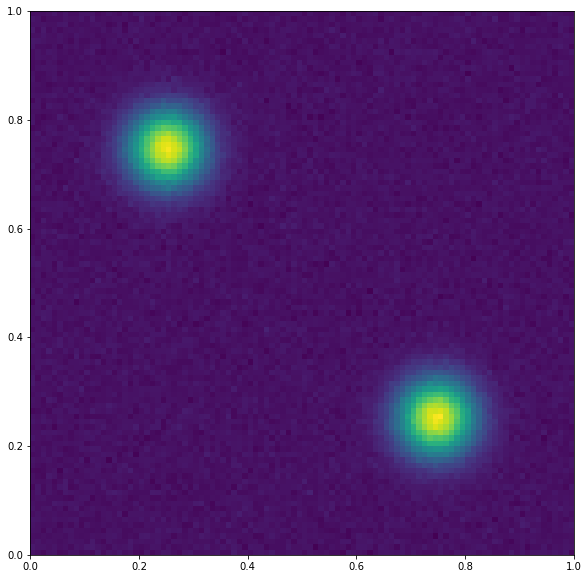

In [2]:
%matplotlib inline
from pylab import *;ion()

from pymultinest.solve import Solver,solve
from numpy import pi, sin, cos, linspace

def gaussian2D(cube):
    center = cube[0]
    width  = cube[1]
    return lambda y,x: np.exp(-0.5*((( (center - y) / width)**2) + (( (center - x) / width)**2))) / sqrt(2*pi*width**2)

np.random.seed(42)

param0a= 0.75#0.05
param1a= 0.05#0.05
param0b= 0.25#0.05
param1b= 0.05#0.05

# param2= 0.8

yunc  = 0.1
nPts  = int(100)
nThPts= int(1e3)

xmin  = -0#*pi
xmax  =  1#*pi
dx    = 0.1*(xmax - xmin)

ymin  = -0#*pi
ymax  =  1#*pi
dy    = 0.1*(ymax - ymin)

model = gaussian2D; parameters = ["center", "width"]

yuncs = np.random.normal(yunc, 1e-2 * yunc, (nPts,nPts))
# thdata= np.linspace(xmin-dx, xmax+dx, nThPts)

xdata = np.ones((nPts,nPts))*np.linspace(xmin,xmax,nPts)
ydata = (np.ones((nPts,nPts))*np.linspace(ymin,ymax,nPts)).T

zmodel  = model([param0a,param1a])(ydata,xdata) + model([param0b,param1b])(ydata,xdata)
zerr    = np.random.normal(0, yuncs, (nPts,nPts))
zdata   = zmodel + zerr

figure(figsize=(10,10))
imshow(zdata, extent=[xdata.min(), xdata.max(), ydata.min(), ydata.max()])

In [3]:
# our probability functions
# Taken from the eggbox problem.
# model = sine_wave; parameters = ["amp", "period"]
# model = gaussian1D; parameters = ["center", "width"]
# model = straight_line; parameters = ["offset", "slope"]

def myprior(cube, ndim, nparams):
    pass

def myloglike(cube, ndim, nparams):
    modelNow = gaussian2D(cube)(ydata,xdata)
    return -0.5*((modelNow - zdata)**2. / yuncs**2.).sum()

def null_loglike(cube, ndim, nparams):
    modelNow = gaussian2D(cube)(ydata,xdata)
    return -0.5*((modelNow)**2. / yuncs**2.).sum()

could not convert string to float: b'-0.367666967019175106-190'
Unknown element o


/Users/jonathan/anaconda3/lib/python3.6/site-packages/numpy/lib/npyio.py:893: UserWarning: loadtxt: Empty input file: "chains/2-phys_live.points"
  warnings.warn('loadtxt: Empty input file: "%s"' % fname)


Wrong number of columns at line 2
  analysing data from chains/2-.txt


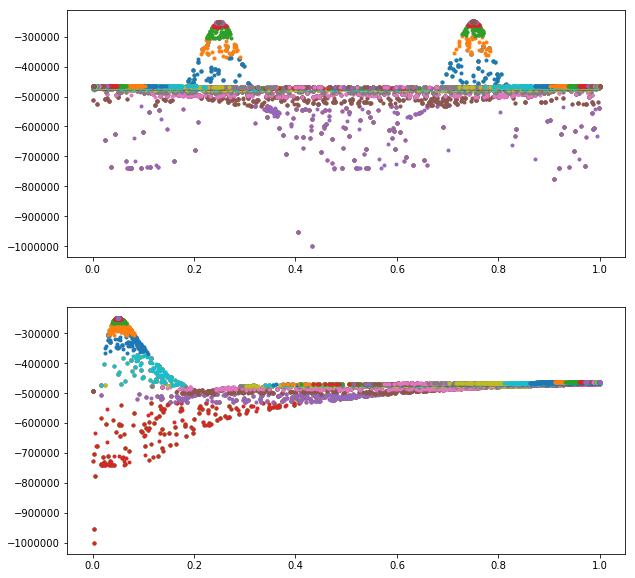

[Errno 2] No such file or directory: 'chains/2-phys_live.points.next.pdf'


In [8]:
if not os.path.exists("chains"): os.mkdir("chains")

# number of dimensions our problem has
# parameters = ["x", "y"]
n_params = len(parameters)

plt.figure(figsize=(5*n_params, 5*n_params))
# we want to see some output while it is running
progress = pymultinest.ProgressPlotter(n_params = n_params, outputfiles_basename='chains/2-'); progress.start()
# threading.Timer(2, show, ["chains/2-phys_live.points.pdf"]).start() # delayed opening
# run MultiNest
pymultinest.run(myloglike, myprior, n_params, importance_nested_sampling = False, \
                resume = False, verbose = True, sampling_efficiency = 'model', n_live_points = 1000, \
                outputfiles_basename='chains/2-')

# NULL EVIDENCE -- PROBABLY WRONG!
# pymultinest.run(null_loglike, myprior, n_params, importance_nested_sampling = False, max_iter = int(1e5), \
#                 resume = False, verbose = True, sampling_efficiency = 'model', n_live_points = 1000, \
#                 outputfiles_basename='chains/2-')

# ok, done. Stop our progress watcher
progress.stop()

# lets analyse the results
a = pymultinest.Analyzer(n_params = n_params, outputfiles_basename='chains/2-')
s = a.get_stats()

# fig = gcf()
# axs  = fig.get_axes()
# for ax in axs:
#     ax.set_ylim(-16,0)

In [6]:
import json

# store name of parameters, always useful
with open('%sparams.json' % a.outputfiles_basename, 'w') as f:
    json.dump(parameters, f, indent=2)
# store derived stats
with open('%sstats.json' % a.outputfiles_basename, mode='w') as f:
    json.dump(s, f, indent=2)

print()
print("-" * 30, 'ANALYSIS', "-" * 30)
print("Global Evidence:\n\t%.15e +- %.15e" % ( s['nested sampling global log-evidence'], s['nested sampling global log-evidence error'] ))

could not convert string to float: b'-0.367666967019175106-190'


NameError: name 's' is not defined

could not convert string to float: b'-0.367666967019175106-190'
could not convert string to float: b'-0.367666967019175106-190'
could not convert string to float: b'-0.367666967019175106-190'
could not convert string to float: b'-0.367666967019175106-190'
could not convert string to float: b'-0.367666967019175106-190'
could not convert string to float: b'-0.367666967019175106-190'
could not convert string to float: b'-0.367666967019175106-190'
could not convert string to float: b'-0.367666967019175106-190'
could not convert string to float: b'-0.367666967019175106-190'
could not convert string to float: b'-0.367666967019175106-190'
could not convert string to float: b'-0.367666967019175106-190'
could not convert string to float: b'-0.367666967019175106-190'
could not convert string to float: b'-0.367666967019175106-190'
could not convert string to float: b'-0.367666967019175106-190'
could not convert string to float: b'-0.367666967019175106-190'
could not convert string to float: b'-0.

In [ ]:
import matplotlib.pyplot as plt
plt.clf()

# Here we will plot all the marginals and whatnot, just to show off
# You may configure the format of the output here, or in matplotlibrc
# All pymultinest does is filling in the data of the plot.

# Copy and edit this file, and play with it.

p = pymultinest.PlotMarginalModes(a)
plt.figure(figsize=(5*n_params, 5*n_params))
#plt.subplots_adjust(wspace=0, hspace=0)
for i in range(n_params):
    plt.subplot(n_params, n_params, n_params * i + i + 1)
    p.plot_marginal(i, with_ellipses = True, with_points = False, grid_points=50)
    plt.ylabel("Probability")
    plt.xlabel(parameters[i])
    
    for j in range(i):
        plt.subplot(n_params, n_params, n_params * j + i + 1)
        #plt.subplots_adjust(left=0, bottom=0, right=0, top=0, wspace=0, hspace=0)
        p.plot_conditional(i, j, with_ellipses = False, with_points = True, grid_points=30)
        plt.xlabel(parameters[i])
        plt.ylabel(parameters[j])

# plt.savefig("chains/marginals_multinest.pdf") #, bbox_inches='tight')
# show("chains/marginals_multinest.pdf")

plt.figure(figsize=(5*n_params, 5*n_params))
plt.subplot2grid((5*n_params, 5*n_params), loc=(0,0))
for i in range(n_params):
    #plt.subplot(n_params, n_params, i + 1)
    # outfile = '%s-mode-marginal-%d.pdf' % (a.outputfiles_basename,i)
    p.plot_modes_marginal(i, with_ellipses = True, with_points = False)
    plt.ylabel("Probability")
    plt.xlabel(parameters[i])
    # plt.savefig(outfile, format='pdf', bbox_inches='tight')
    # plt.close()
    
    # outfile = '%s-mode-marginal-cumulative-%d.pdf' % (a.outputfiles_basename,i)
    p.plot_modes_marginal(i, cumulative = True, with_ellipses = True, with_points = False)
    plt.ylabel("Cumulative probability")
    plt.xlabel(parameters[i])
    # plt.savefig(outfile, format='pdf', bbox_inches='tight')
    # plt.close()

print("Take a look at the pdf files in chains/") 

In [ ]:
print('best\t', np.round(p.analyser.get_best_fit()['parameters'],3))
for k,mode in enumerate(p.analyser.get_stats()['modes']):
    print('mode' + str(k) + '\t', np.round(mode['mean'],3),'\t', np.round(mode['local log-evidence'],3))

print('True a\t', [param0a, param1a])
print('True b\t', [param0b, param1b])

In [ ]:
modelAll = np.zeros((nPts, nPts))
fig=figure(figsize=(20,10))
for km,mode in enumerate(p.analyser.get_stats()['modes']):
    modelAll = modelAll + model(mode['mean'])(ydata,xdata)
    ax = fig.add_subplot(1,len(p.analyser.get_stats()['modes']), km+1)
    ims = ax.imshow(model(mode['mean'])(ydata,xdata))
    plt.colorbar(ims)

fig = figure(figsize=(20,10))
ax = fig.add_subplot(131)
ims = ax.imshow(modelAll)
plt.colorbar(ims)
ax = fig.add_subplot(132)
ims = ax.imshow(model(p.analyser.get_best_fit()['parameters'])(ydata,xdata))
plt.colorbar(ims)
ax = fig.add_subplot(133)
ims = ax.imshow(zdata)
plt.colorbar(ims)

# Residuals
modelAll = np.zeros((nPts, nPts))
for km,mode in enumerate(p.analyser.get_stats()['modes']):
    if np.round(mode['local log-evidence'],3) > -400000.:
        modelAll = modelAll + model(mode['mean'])(ydata,xdata)

fig = figure(figsize=(20,10))
ax  = fig.add_subplot(131)
ims = ax.imshow(zdata - modelAll)
plt.colorbar(ims)
ax  = fig.add_subplot(132)
ax.hist((zdata - modelAll).ravel(), bins=1000, normed=True);
# plt.colorbar(ims)

In [ ]:
p.analyser.get_stats()

** BROKEN BELOW**

# PyMultiNest Learning Tutorial

CCT = Charge Carrier Trapping - This is a test of comparing the Zhou et al 2017 results with a data driven analysis using multinest

In [ ]:
%matplotlib inline
from pylab import *;ion()
from pandas import read_csv

In [ ]:
import os
if not os.path.exists('chains/'):
    os.mkdir('chains')

print(os.path.exists('chains'))

# PyMultiNest Solver Class

**Initial Example**

In [ ]:
#!/usr/bin/env python
from pymultinest.solve import Solver
from numpy import pi, sin

class EggboxProblem(Solver):
    def Prior(self, cube):
        return cube * 10 * pi
    def LogLikelihood(self, cube):
        chi = (sin(cube)).prod()
        return (2. + chi)**5

solution = EggboxProblem(n_dims = 1)
print(solution)
solution = EggboxProblem(n_dims = 2)
print(solution)

**My PyMultiNest Test**

In [ ]:
%matplotlib inline
from pylab import *;ion()

from pymultinest.solve import Solver,solve
from numpy import pi, sin, cos, linspace

def straight_line(cube):
    offset = cube[0]
    slope  = cube[1]
    return lambda abscissa: offset + slope * abscissa

def sine_wave(cube):
    amp    = cube[0]
    period = cube[1]
    return lambda abscissa: amp*sin(2*pi / period * abscissa)

np.random.seed(0)

param0= 0.1#0.05
param1= 0.1#5*pi
yunc  = 0.025
nPts  = int(10)
nThPts= int(1e3)

xmin  = -0.5*pi
xmax  =  0.5*pi
dx    = 0.1*(xmax - xmin)

# model = sine_wave
model = straight_line

yuncs = np.random.normal(yunc, 1e-2 * yunc, nPts)
thdata= np.linspace(xmin-dx, xmax+dx, nThPts)

xdata = np.random.uniform(xmin, xmax, nPts)
xdata = sort(xdata)

ydata = model([param0,param1])(xdata)

yerr  = np.random.normal(0, yuncs, nPts)
zdata = ydata + yerr

figure(figsize=(20,5))
plot(thdata, model([param0, param1])(thdata))
errorbar(xdata, zdata, yuncs, fmt='o')

In [ ]:
class ChisqFit(Solver):
    def Prior(self, cube):
        return cube
    
    def LogLikelihood(self, cube):
        chisq = (-0.5*((model(cube)(xdata) - ydata)**2.) )#/ yuncs**2.
        return chisq.prod()

# solution = ChisqFit(n_dims = 2, resume=False, outputfiles_basename='./42-')

solution = ChisqFit(n_dims = 2, n_params=None, n_clustering_params=None, wrapped_params=None        , \
                    importance_nested_sampling=True, multimodal=True, const_efficiency_mode=False   , \
                    n_live_points=400, evidence_tolerance=0.5, sampling_efficiency=0.8              , \
                    n_iter_before_update=100, null_log_evidence=-1e+90, max_modes=100               , \
                    mode_tolerance=-1e+90, outputfiles_basename='chains/1-', seed=-1, verbose=False , \
                    resume=False, context=0, write_output=True, log_zero=-1e+100, max_iter=0         , \
                    init_MPI=False, dump_callback=None)
print(solution)

**Simplest Example**

In [ ]:
if not os.path.exists("chains"): os.mkdir("chains")

import pymultinest

def prior(cube, ndim, nparams):
    cube[0] = cube[0] * 2

def loglikelihood(cube, ndim, nparams):
    return ((cube[0] - 0.2) / 0.1)**2

pymultinest.run(loglikelihood, prior, n_dims=1, max_iter=2)

# PyMultiNest Solve Function

In [ ]:
#!/usr/bin/env python
from __future__ import absolute_import, unicode_literals, print_function
import numpy
from numpy import pi, cos
from pymultinest.solve import solve
import os

if not os.path.exists("chains"): os.mkdir("chains")

# probability function, taken from the eggbox problem.

def myprior(cube):
    return cube * 10 * pi

def myloglike(cube):
    chi = (cos(cube / 2.)).prod()
    return (2. + chi)**5

In [ ]:
# number of dimensions our problem has
parameters = ["x", "y"]
n_params = len(parameters)

# run MultiNest
result = solve(LogLikelihood=myloglike, Prior=myprior, 
    n_dims=n_params, outputfiles_basename="chains/3-")

print()
print('evidence: %(logZ).1f +- %(logZerr).1f' % result)
print()
print('parameter values:')
for name, col in zip(parameters, result['samples'].transpose()):
    print('%15s : %.3f +- %.3f' % (name, col.mean(), col.std()))